In [7]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from random import shuffle
import time

In [1]:
# Path: train and test directories
TRAIN_DIR = 'data/train/'
TEST_DIR = 'data/test/'

# image size for training and testing
IMG_SIZE = 64

In [2]:
# Assigning labels: cats-->[1,0] and dogs-->[0,1]: 
def label_img(img):
    label_name = img.split('.')[-3]
    
    if label_name == 'cat': label = [1,0]
    elif label_name == 'dog': label = [0,1]
    else : print('no label for the image:', img)
        
    return label    

In [3]:
# pre-processing to generate training data
def process_train_data():
    training_data = []

    for img in os.listdir(TRAIN_DIR):

        label = label_img(img)
        img = cv2.resize(cv2.imread(os.path.join(TRAIN_DIR,img),cv2.IMREAD_GRAYSCALE), (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data      

In [5]:
# pre-processing to generate test data
def process_test_data():
    testing_data = []
    for img in os.listdir(TEST_DIR):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [8]:
train_data =  process_train_data()
test_data = process_test_data()

In [10]:
print('Total training images:',len(train_data))
print('Total test images:',len(test_data))

ncat = 0; ndog = 0; noLabel = 0
for img in os.listdir(TRAIN_DIR):
    if img.split('.')[-3] == 'cat': ncat +=1
    elif img.split('.')[-3] == 'dog': ndog +=1
    else: noLabel +=1
print('cats:',  ncat)
print('dogs:', ndog)
print('Without label:',noLabel)


Total training images: 25000
Total test images: 12500
cats: 12500
dogs: 12500
Without label: 0


In [11]:
# 5000 images are taken out of training set for validation
train_dataset = train_data[:-5000]
val_dataset = train_data[-5000:]

X_train = np.array([smp[0] for smp in train_dataset]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
X_train = X_train/255
Y_train = np.array([smp[1] for smp in train_dataset])



X_val = np.array([smp[0] for smp in val_dataset]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
X_val = X_val/255
Y_val = np.array([smp[1] for smp in val_dataset])

X_test = np.array([smp[0] for smp in test_data]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
X_test = X_test/255

# Only 5000 images are being used for training

X_train = X_train[:3000]
Y_train = Y_train[:3000]


print('# of samples used for training',len(X_train))
print('# of samples used for validation',len(X_val))

# of samples used for training 3000
# of samples used for validation 5000


In [13]:
print('Hopefully training set is balanced... let us see\n')
print('# of cats in the training:',sum(Y_train[:,0]))
print('# of dogs in the training:',sum(Y_train[:,1]),'\n')

print('And validation set......? \n')
print('# of cats in the validation:',sum(Y_val[:,0]))
print('# of dogs in the validation:',sum(Y_val[:,1]))

Hopefully training set is balanced... let us see

# of cats in the training: 1509
# of dogs in the training: 1491 

And validation set......? 

# of cats in the validation: 2499
# of dogs in the validation: 2501


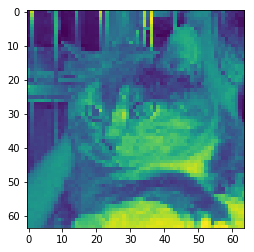

[1 0]


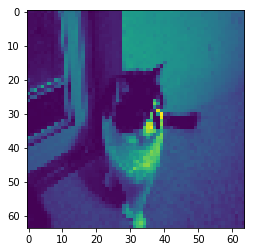

[1 0]


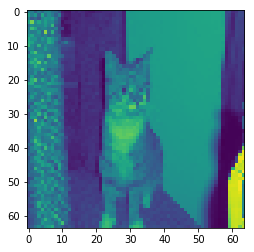

[1 0]


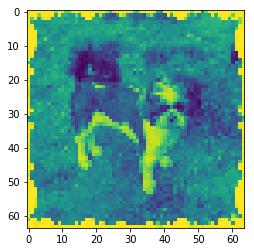

[0 1]
=====VALIDATION DATSET=========


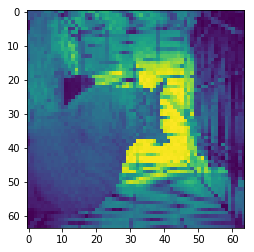

[1 0]


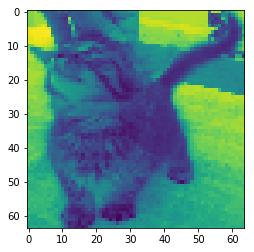

[1 0]


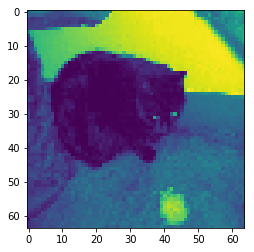

[1 0]


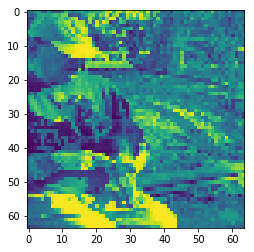

[0 1]
=====TEST DATSET=========


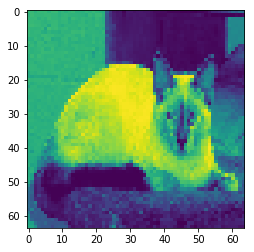

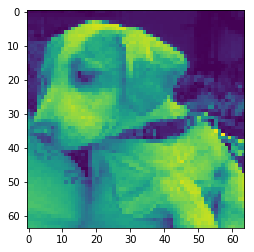

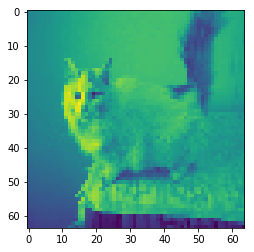

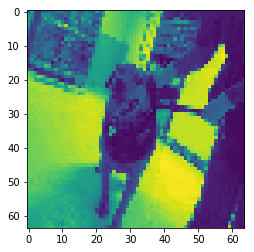

In [14]:
# Displaying a few train, validation and test samples

for i in range(4):
    n = np.random.randint(1,len(X_train))
    sample = X_train[n,:,:,:]
    sample = sample.reshape(sample.shape[0], sample.shape[1]).astype(np.float32)
    plt.imshow(sample)
    plt.show()
    print(Y_train[n])
    
print('=====VALIDATION DATSET=========')

for i in range(4):
    n = np.random.randint(1,len(X_val))
    sample = X_val[n,:,:,:]
    sample = sample.reshape(sample.shape[0], sample.shape[1]).astype(np.float32)
    plt.imshow(sample)
    plt.show()
    print(Y_val[n])   
    
    
print('=====TEST DATSET=========')

for i in range(4):
    n = np.random.randint(1,len(X_test))
    sample = X_test[n,:,:,:]
    sample = sample.reshape(sample.shape[0], sample.shape[1]).astype(np.float32)
    plt.imshow(sample)
    plt.show()


In [51]:
IMG_SIZE = 64
BATCH_SIZE = 64
TEST_BATCH_SIZE = 1
# Depth is the number of output channels 
# On the other hand, num_channels is the number of input channels set at 1 previously
CHANNELS = 1
DEPTH1 = 32
DEPTH2 = 64
DEPTH3 = 64
DEPTH4 = 128
convolved_img = 4096#8192
FC1_UNITS = 256  #conolved_image * conolved_image * depth4
fc2_units = 512
BETA = 0.001
NUM_LABELS = 2
PATCH_SIZE = 3

TEST_SAMP = 10000

KEEP_RATE = 0.8
# KEEP_PROB = tf.placeholder(tf.float32)

graph = tf.Graph()

with graph.as_default():
    KEEP_PROB = tf.placeholder(tf.float32)
    tf_train_dataset = tf.placeholder(tf.float32, shape=(BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS))
    tf_train_labels = tf.placeholder(tf.int64, shape=(BATCH_SIZE, NUM_LABELS))
    
    tf_val_dataset = tf.placeholder(tf.float32, shape=(2*BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS))
    tf_val_labels = tf.placeholder(tf.int64, shape=(2*BATCH_SIZE, NUM_LABELS))
    
    
    tf_test_dataset = tf.placeholder(tf.float32, shape=(TEST_BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS))
    # variables===========
    
    l1_conv_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, CHANNELS, DEPTH1], stddev=0.1))
    l1_biases = tf.Variable(tf.constant(1.0, shape=[DEPTH1]))
    
    l2_conv_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH1, DEPTH2], stddev=0.1))
    l2_biases = tf.Variable(tf.constant(1.0, shape=[DEPTH2]))
    
    l3_conv_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH2, DEPTH3], stddev=0.1))
    l3_biases = tf.Variable(tf.constant(1.0, shape=[DEPTH3]))

    l_fc_weights = tf.Variable(tf.truncated_normal([convolved_img, FC1_UNITS], stddev=0.1))
    l_fc_biases = tf.Variable(tf.constant(1.0, shape=[FC1_UNITS]))
    
    ol_weights = tf.Variable(tf.truncated_normal([FC1_UNITS, NUM_LABELS], stddev=0.1))
    
    ol_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
    
    
    
    def model(data):
        conv_1 = tf.nn.conv2d(data, l1_conv_weights, strides=[1, 1, 1, 1], padding='SAME')
        conv_1 = tf.nn.relu(conv_1 + l1_biases)
        pool_1 = tf.nn.avg_pool(conv_1, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
#         norm_1 = tf.nn.local_response_normalization(pool_1)
        
        # Second Convolutional Layer with Pooling
        conv_2 = tf.nn.conv2d(pool_1, l2_conv_weights, strides=[1, 1, 1, 1], padding='SAME')
        conv_2 = tf.nn.relu(conv_2 + l2_biases)
        pool_2 = tf.nn.avg_pool(conv_2, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
#         norm_2 = tf.nn.local_response_normalization(pool_2)
        conv_3 = tf.nn.conv2d(pool_2, l3_conv_weights, strides=[1, 1, 1, 1], padding='SAME')
        conv_3 = tf.nn.relu(conv_3 + l3_biases)
        pool_3 = tf.nn.avg_pool(conv_3, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        
        shape = pool_3.get_shape().as_list()   
        
#         print('shape:',shape[3])

        shape = tf.reshape(pool_3, [shape[0], shape[1] * shape[2] * shape[3]])
        
        
        fc1 = tf.add(tf.matmul(shape, l_fc_weights), l_fc_biases)
        fc1_do = tf.nn.dropout(fc1, KEEP_RATE)
        fc_1_do = tf.nn.relu(fc1_do)
        
        logit = (tf.matmul(fc_1_do, ol_weights) + ol_biases)
        
        return logit
    

    logit = model(tf_train_dataset)

    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels =tf_train_labels ,logits = logit))
    optimizer = tf.train.AdagradOptimizer(0.05).minimize(loss)

    train_prediction = tf.nn.softmax(model(tf_train_dataset))
    valid_prediction = tf.nn.softmax(model(tf_val_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))
    
    
    saver = tf.train.Saver()


In [52]:
def accuracy(predictions, labels):
    correct_prediction = (np.argmax(predictions, 1) == np.argmax(labels, 1))
    
    acc = 100*(np.sum(correct_prediction))/labels.shape[0]
    
    return acc

In [55]:
NUM_STEPS = 8000# BATCH_SIZE = 128
validate = NUM_STEPS//100

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
#   sp = saver.restore(session, "../SVHN-CNN-sequence-L2.ckpt")
#   print('Model Restored')
  print('Initialized')
  start = time.time()

  for step in range(NUM_STEPS): 
    
    offset = (step * BATCH_SIZE) % (Y_train.shape[0] - BATCH_SIZE)
    batch_data = X_train[offset:(offset + BATCH_SIZE), :, :, :]
    batch_labels = Y_train[offset:(offset + BATCH_SIZE),:]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if (step % validate == 0):
    
      print('# of step:', step)
      print('Minibatch loss at step %d: %.2f' % (step, l))
      print('training accuracy %.1f' % accuracy(predictions, batch_labels))
        
       
      offset = np.random.randint(0,(130-2*BATCH_SIZE))
      batch_data = X_val[offset:(offset + 2*BATCH_SIZE), :, :, :]
      batch_labels = Y_val[offset:(offset + 2*BATCH_SIZE),:]
      feed_dict = {tf_val_dataset : batch_data, tf_val_labels : batch_labels}
    
        
      print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(feed_dict = {tf_val_dataset : batch_data}), batch_labels))
      print ('Time for completing %d steps: %.4s minutes' %(validate, (time.time() - start)/60))
      start = time.time()
      print('=' *20)
      
  sp = saver.save(session, "./cat_and_dog.ckpt")
  print('Model Saved')

       
print('END')

Initialized
# of step: 0
Minibatch loss at step 0: 7.87
training accuracy 54.7
Validation accuracy: 51.6%
Time for completing 80 steps: 0.01 minutes
# of step: 80
Minibatch loss at step 80: 0.69
training accuracy 45.3
Validation accuracy: 55.5%
Time for completing 80 steps: 0.78 minutes
# of step: 160
Minibatch loss at step 160: 0.68
training accuracy 53.1
Validation accuracy: 57.0%
Time for completing 80 steps: 0.80 minutes
# of step: 240
Minibatch loss at step 240: 0.70
training accuracy 53.1
Validation accuracy: 57.0%
Time for completing 80 steps: 0.81 minutes
# of step: 320
Minibatch loss at step 320: 0.69
training accuracy 59.4
Validation accuracy: 54.7%
Time for completing 80 steps: 0.85 minutes
# of step: 400
Minibatch loss at step 400: 0.68
training accuracy 60.9
Validation accuracy: 57.0%
Time for completing 80 steps: 0.83 minutes
# of step: 480
Minibatch loss at step 480: 0.63
training accuracy 65.6
Validation accuracy: 55.5%
Time for completing 80 steps: 0.84 minutes
# of st

Validation accuracy: 62.5%
Time for completing 80 steps: 0.78 minutes
# of step: 4080
Minibatch loss at step 4080: 0.56
training accuracy 79.7
Validation accuracy: 56.2%
Time for completing 80 steps: 0.77 minutes
# of step: 4160
Minibatch loss at step 4160: 0.49
training accuracy 71.9
Validation accuracy: 61.7%
Time for completing 80 steps: 0.77 minutes
# of step: 4240
Minibatch loss at step 4240: 0.54
training accuracy 76.6
Validation accuracy: 62.5%
Time for completing 80 steps: 0.80 minutes
# of step: 4320
Minibatch loss at step 4320: 0.56
training accuracy 73.4
Validation accuracy: 60.2%
Time for completing 80 steps: 0.76 minutes
# of step: 4400
Minibatch loss at step 4400: 0.42
training accuracy 76.6
Validation accuracy: 56.2%
Time for completing 80 steps: 0.79 minutes
# of step: 4480
Minibatch loss at step 4480: 0.47
training accuracy 73.4
Validation accuracy: 60.2%
Time for completing 80 steps: 0.83 minutes
# of step: 4560
Minibatch loss at step 4560: 0.45
training accuracy 76.6

INFO:tensorflow:Restoring parameters from ./cat_and_dog.ckpt
Model restored.
It is most probably a DOG


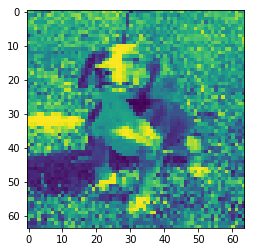

In [69]:
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()

  # Restore variables from disk.

#   tf_saver = tf.train.Saver()
  saver.restore(session, "./cat_and_dog.ckpt")
  print("Model restored.")

  rn = np.random.randint(1, len(X_test))
  X_ts = sample = X_test[rn:(rn+1),:,:,:]


  classification = test_prediction.eval(feed_dict ={tf_test_dataset : sample})    
  
#   print(np.argmax(classification, 1))
    
  if np.argmax(classification, 1) == 0: print('It is most probably a CAT')
  else: print('It is most probably a DOG')
    
  sample = sample.reshape(sample.shape[1], sample.shape[2]).astype(np.float32)
  plt.imshow(sample)
  plt.show()
